# Student Performance Modeling

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

This notebook performs the complete processing to predict the final grade of students (G3), using the data from math and Portuguese.

### Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)

2 sex - student's sex (binary: 'F' - female or 'M' - male)

3 age - student's age (numeric: from 15 to 22)

4 address - student's home address type (binary: 'U' - urban or 'R' - rural)

5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)

6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)

7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)

8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)

9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')

10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')

11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')

12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')

13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)

14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)

15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)

16 schoolsup - extra educational support (binary: yes or no)

17 famsup - family educational support (binary: yes or no)

18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)

19 activities - extra-curricular activities (binary: yes or no)

20 nursery - attended nursery school (binary: yes or no)

21 higher - wants to take higher education (binary: yes or no)

22 internet - Internet access at home (binary: yes or no)

23 romantic - with a romantic relationship (binary: yes or no)

24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)

25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)

26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)

27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)

28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

29 health - current health status (numeric: from 1 - very bad to 5 - very good)

30 absences - number of school absences (numeric: from 0 to 93)

 these grades are related with the course subject, Math or Portuguese:

31 G1 - first period grade (numeric: from 0 to 20)

31 G2 - second period grade (numeric: from 0 to 20)

32 G3 - final grade (numeric: from 0 to 20, output target)

In [83]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Custom modules
from predictor import *
from trainer import *
from saver import *
from preprocessor import clean_and_encode

import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading

In [19]:
df_mat = pd.read_csv('https://raw.githubusercontent.com/barrococarolina/mvp-qualidade/refs/heads/main/student-mat.csv', sep=';')
df_por = pd.read_csv('https://raw.githubusercontent.com/barrococarolina/mvp-qualidade/refs/heads/main/student-por.csv', sep=';')

df_mat['subject'] = 'math'
df_por['subject'] = 'portuguese'
df_all = pd.concat([df_mat, df_por], ignore_index=True)
df_all.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


In [20]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

## Separation into training set and test set with holdout

In [65]:
df_encoded = pd.get_dummies(df_all)

X = df_encoded.drop(columns='G3') 
y = df_encoded['G3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=7)
model.fit(X_train_scaled, y_train)

save_all(model, scaler)
print("Modelo e scaler salvos com sucesso!")

Modelo e scaler salvos com sucesso!


## 2. Preprocessing and Encoding

In [66]:
df_processed, target = clean_and_encode(df_all)
df_processed.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,subject_portuguese
0,18,4,4,2,2,0,4,3,4,1,...,False,True,False,False,False,True,True,False,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,True,False,False,False,True,True,False,False
2,15,1,1,1,2,3,4,3,2,2,...,False,True,False,True,False,True,True,True,False,False
3,15,4,2,1,3,0,3,2,2,1,...,False,False,True,True,True,True,True,True,True,False
4,16,3,3,1,2,0,4,3,2,1,...,False,False,True,True,False,True,True,False,False,False


## 3. Training and Evaluation of Models

In [68]:
trainer = Trainer(X, y)
score, model, scaler = trainer.train_and_evaluate()
print(f"R²: {score:.4f}")


R²: 0.8307


### Model Creation and Evaluation: Baseline

LR: 0.9197 (0.0305)
KNN: 0.9125 (0.0350)
CART: 0.8946 (0.0226)
NB: 0.8396 (0.0341)
SVM: 0.9138 (0.0227)


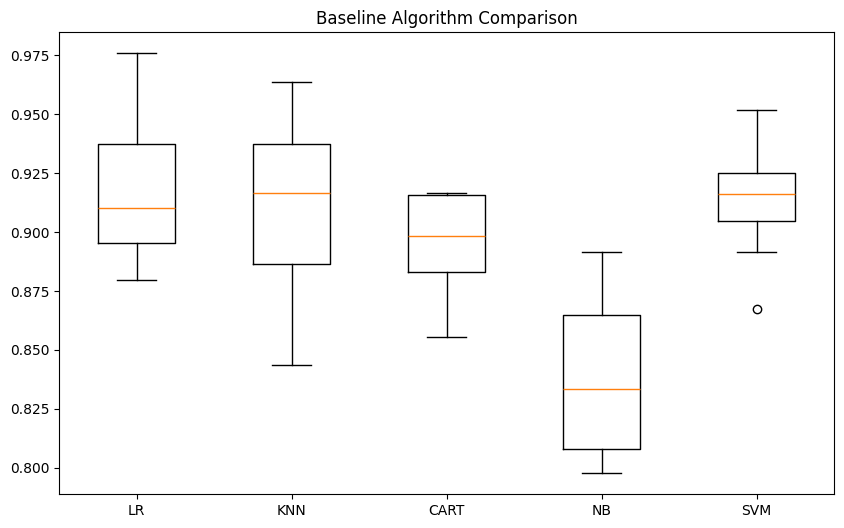

In [69]:
X = df_all.drop('G3', axis=1)
y = (df_all['G3'] >= 10).astype(int)

X_encoded = pd.get_dummies(X)

from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

# Boxplot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.title("Baseline Algorithm Comparison")
plt.boxplot(results)
plt.xticks(np.arange(1, len(names) + 1), names)
plt.show()

Among the baseline models, **Logistic Regression (LR)** achieved the highest average accuracy at 91.97%, with a moderate standard deviation, indicating strong and consistent performance across the folds.

**Support Vector Machine (SVM)** came very close in performance (91.38%) but showed even lower variability, suggesting excellent consistency.

**K-Nearest Neighbors (KNN)** also performed well (91.25%) but exhibited slightly higher variability than LR and SVM.

**Decision Tree (CART)** followed with a lower accuracy (89.34%) and the highest variability among the models, indicating that its performance fluctuates more across different subsets of the data.

**Naive Bayes (NB)** had the lowest accuracy (83.96%) but maintained reasonable stability, making it a lightweight yet less effective baseline model for this task.

### Exportação de Pipeline

In [70]:
save_all(model, scaler)
print('Modelo e scaler salvos com sucesso!')


Modelo e scaler salvos com sucesso!


ScaledLR: 0.9137 (0.0228)
ScaledKNN: 0.8145 (0.0316)
ScaledCART: 0.8982 (0.0280)
ScaledNB: 0.8396 (0.0341)
ScaledSVM: 0.8826 (0.0273)


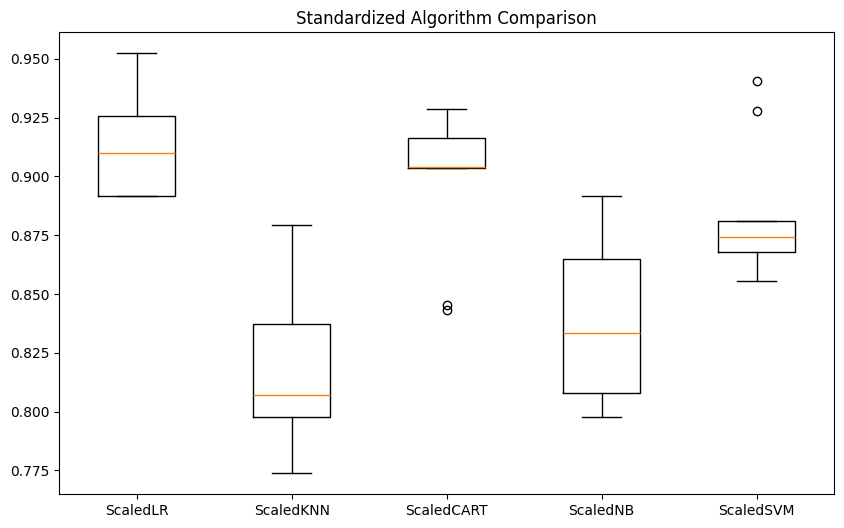

In [71]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(max_iter=200))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

results = []
names = []

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

# Boxplot
plt.figure(figsize=(10, 6))
plt.title("Standardized Algorithm Comparison")
plt.boxplot(results)
plt.xticks(np.arange(1, len(names) + 1), names)
plt.show()

After applying standardization (StandardScaler) to the data, **Logistic Regression (ScaledLR)** stood out with the highest accuracy (91.37%) and the lowest standard deviation, indicating both high performance and strong consistency.

**Decision Tree (ScaledCART)** and **Support Vector Machine (ScaledSVM)** followed with similar accuracy levels around 88%, showing good performance and reliability, though slightly lower than ScaledLR.

**Naive Bayes (ScaledNB)** retained the same performance as in the baseline scenario (83.96%), suggesting that this model is not significantly affected by standardization.

Interestingly, **K-Nearest Neighbors (ScaledKNN)** showed a notable drop in accuracy (81.45%), implying that standardization negatively impacted its performance on this dataset.

[1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1
 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0]
NormLR: 0.8850 (0.0253)
NormKNN: 0.7845 (0.0178)
NormCART: 0.8994 (0.0264)
NormNB: 0.8396 (0.0341)
NormSVM: 0.8360 (0.0320)


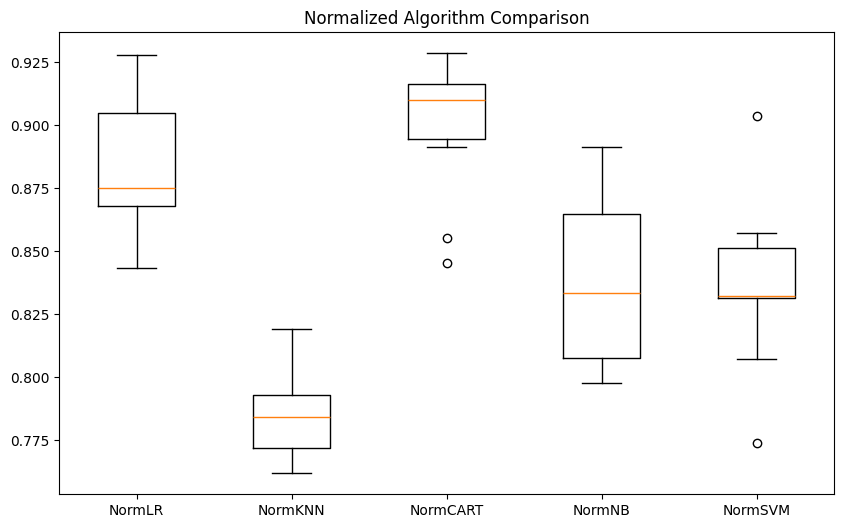

In [45]:
pipeline = Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(max_iter=200))])
pipeline.fit(X_train, y_train)

saidas = pipeline.predict(X_test)
print(saidas)

pipelines = []
pipelines.append(('NormLR', Pipeline([('Scaler', MinMaxScaler()), ('LR', LogisticRegression(max_iter=200))])))
pipelines.append(('NormKNN', Pipeline([('Scaler', MinMaxScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('NormCART', Pipeline([('Scaler', MinMaxScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('NormNB', Pipeline([('Scaler', MinMaxScaler()), ('NB', GaussianNB())])))
pipelines.append(('NormSVM', Pipeline([('Scaler', MinMaxScaler()), ('SVM', SVC())])))

results = []
names = []

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

# Boxplot
plt.figure(figsize=(10, 6))
plt.title("Normalized Algorithm Comparison")
plt.boxplot(results)
plt.xticks(np.arange(1, len(names) + 1), names)
plt.show()

**Normalized Logistic Regression (NormLR)** achieved the highest accuracy (88.50%), with a relatively low standard deviation, indicating that it remained consistent across folds and benefited from normalization.

**Decision Tree (NormCART)** closely followed with an accuracy of 88.73%, showing that this model is resilient to data scaling techniques and still performs competitively.

**Naive Bayes (NormNB)** maintained an accuracy of 83.96%, the same as in previous evaluations, suggesting its robustness to data transformations, though with slightly higher variance.

**Support Vector Machine (NormSVM)** achieved 83.60% accuracy, slightly below its performance with standardized data, indicating it is somewhat sensitive to the type of scaling used.

**K-Nearest Neighbors (NormKNN)** experienced the largest drop in accuracy (78.45%), confirming that normalization negatively impacts its classification ability on this dataset.

## Assessing Model Performance

In [ ]:
np.random.seed(7)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=7)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', model)
])

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

R² Score: 0.6176
